# Data Preparation

In [1]:
import requests
import pandas as pd
from datetime import datetime
import csv
from matplotlib import pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer


# Data Acquisition and Understanding

### Goal:
Basically, the project is to segment the most similar subreddit to a user based on the similarity of the post that user is interacting with (may including upvotes and comments). Analyse and understand the data, perform EDA to ensure data collected is reliable for effective decision making.
1. <b>Text Processing</b> - We cannot do any meaningful EDA before text processing. So, by removing noises and preparing for a cleaner unstructured corpus, we can gain useful insights that might give an idea to do feature engineering.
2. <b>EDA</b> - Able to expose the data in terms of anomalies. Assess and validate our assumptions that is claim to be related to our business context.

## Text Processing

In [2]:
pd.set_option("display.max_columns", None)
submission_df = pd.read_csv('submissions.csv')
submission_df.head()

id kind  category   created_utc                author       name  \
0  slzdzs   t3       NaN  1.644162e+09  Independent_Bee_4468  t3_slzdzs   
1  qrti73   t3       NaN  1.636660e+09          TopSpite9394  t3_qrti73   
2  p1se4g   t3       NaN  1.628612e+09             villanegg  t3_p1se4g   
3  oeiaps   t3       NaN  1.625525e+09        Cristheideaman  t3_oeiaps   
4  nadi4r   t3       NaN  1.620784e+09        Nahughes121989  t3_nadi4r   

  subreddit_id  subreddit_subscriber subreddit  \
0     t5_2qs0k                 51514      Home   
1     t5_2qs0k                 51514      Home   
2     t5_2qs0k                 51514      Home   
3     t5_2qs0k                 51514      Home   
4     t5_2qs0k                 51514      Home   

                                               title selftext  upvote_ratio  \
0  What is this mud-like lump that recently appea...      NaN          0.50   
1  Any idea what this is? Sorry if this is a dumb...      NaN          0.60   
2            I just bought my first flat. First pic!      NaN          0.53   
3  Exterior project my family completed follow on...      NaN          0.50   
4  Loving my new living room setup. Just need a p...      NaN          0.59   

                                     url  num_comments  ups  downs  \
0  https://www.reddit.com/gallery/slzdzs            28    0      0   
1  https://www.reddit.com/gallery/qrti73            24   15      0   
2    https://i.redd.it/ygtww9pv1kg71.jpg             6    1      0   
3        https://v.redd.it/sd1smhg84h971             0    0      0   
4    https://i.redd.it/gt880tx8hly61.jpg            11    6      0   

   total_awards_received  score       created  num_crossposts  
0                      0      0  1.644162e+09               0  
1                      0     15  1.636660e+09               0  
2                      0      1  1.628612e+09               0  
3                      0      0  1.625525e+09               0  
4                      0      6  1.620784e+09               0

In [3]:
submission_df = submission_df.dropna(subset=['title'])
group_submission = submission_df[['subreddit', 'title']].groupby('subreddit')
submission_corpus = group_submission['title'].apply(lambda txt: ". ".join(txt)).reset_index()
submission_corpus.head()

subreddit                                              title
0      2007scape  I was trying to record this potential scammer ...
1     3Dprinting  Official Response from Cults regarding the u/B...
2  AmItheAsshole  AITA for having my 18 year old daughter pay fo...
3         AskMen  What is your experience with quiet girls?. Wha...
4      AskReddit  Would you refrain from masturbation or sex for...

In [5]:
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
STOPWORDS = set(stopwords.words('english'))

def data_cleaning(txt):
    txt = txt.translate(str.maketrans('', '', string.punctuation))
    txt = " ".join([word for word in txt.split() if word not in STOPWORDS])
    pos_tagged_text = nltk.pos_tag(txt.split())
    txt = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
    return txt
    
submission_corpus['title'] = submission_corpus["title"].apply(lambda x: data_cleaning(x))
submission_corpus.head()

subreddit                                              title
0      2007scape  I try record potential scammer actually glitch...
1     3Dprinting  Official Response Cults regard uBigbore729 cas...
2  AmItheAsshole  AITA 18 year old daughter pay feminine hygiene...
3         AskMen  What experience quiet girl What tell partner o...
4      AskReddit  Would refrain masturbation sex 365 day 1000000...

## Exploratory Data Analysis (EDA) 
The purpose here is to figure out the trends in the reddit corpus by summarizing the main features using various visualization techniques. Analyzing the data by generating simple statistics and making sense of it. 
- Most frequent words
- Vocabulary

## Most Frequent Words

In [6]:
from collections import Counter

cnt = Counter()
for text in submission_corpus['title'].values:
    for word in text.split():
        cnt[word] += 1

common_df = pd.DataFrame()
common_df["word"] = [w for (w, wc) in cnt.most_common(50)]
common_df["frequency"] = [wc for (w, wc) in cnt.most_common(50)]
common_df.head()

word  frequency
0     I       3237
1   The       1174
2   get       1110
3  make        787
4   Why        770

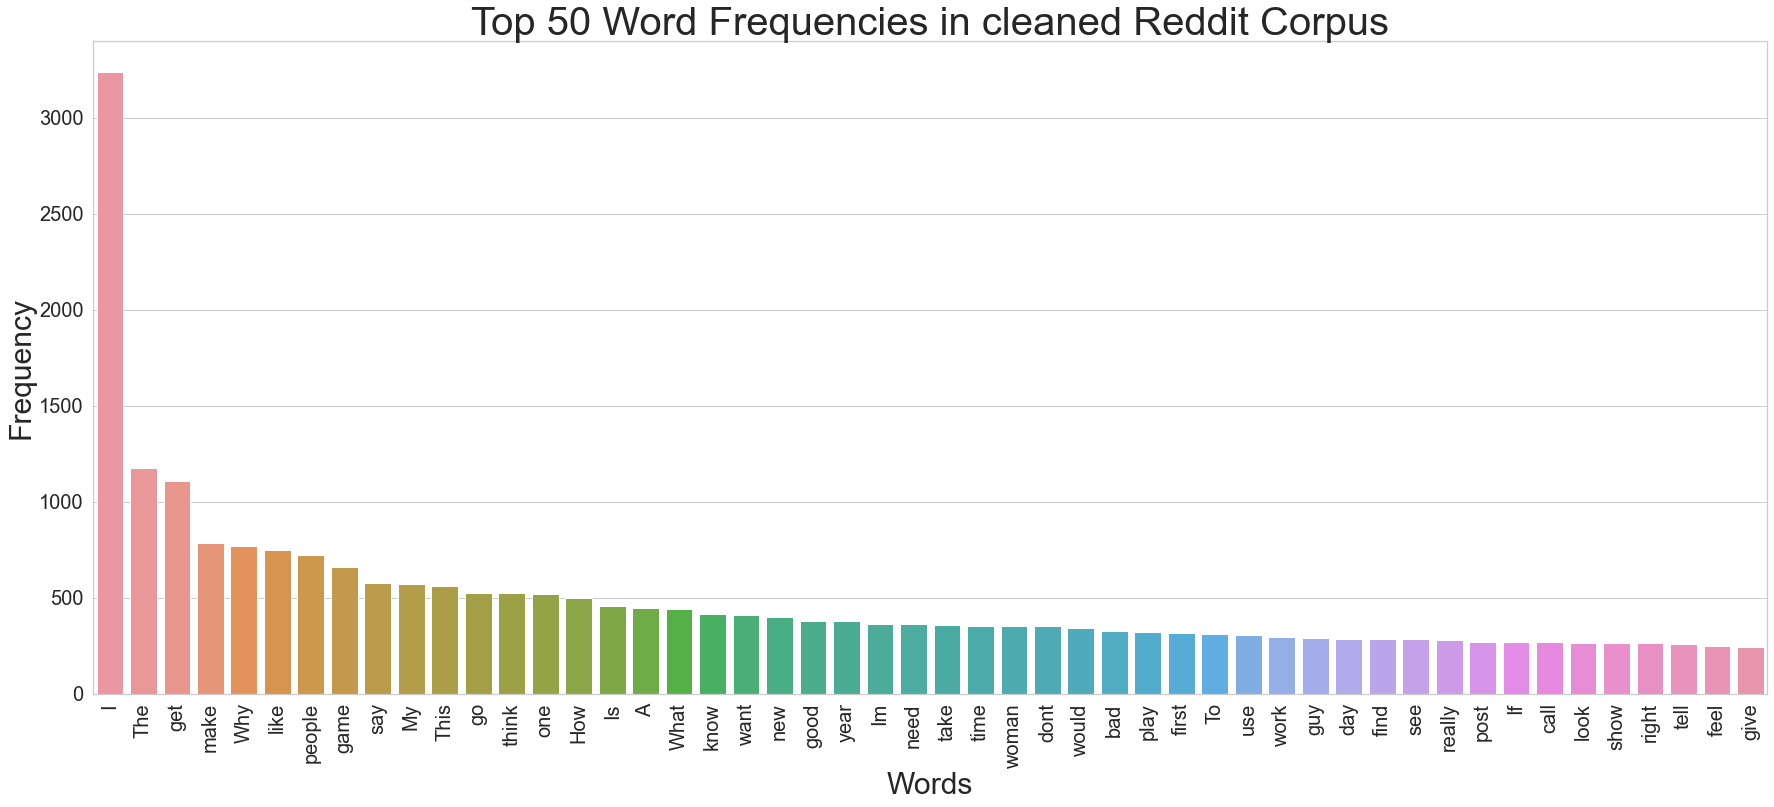

In [7]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [30, 12]
sns.set_theme(style="whitegrid")
bp = sns.barplot(x="word", y="frequency", data=common_df)
bp.axes.set_title("Top 50 Word Frequencies in cleaned Reddit Corpus",fontsize=40)
bp.set_xlabel("Words",fontsize=30)
bp.set_ylabel("Frequency",fontsize=30)
bp.tick_params(labelsize=20, axis='x', rotation=90)
bp.tick_params(labelsize=20, axis='y')
plt.show()

In [9]:
# my_stop_words = ['like', 'just', 'https', 'com']
# stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)
from sklearn.feature_extraction import text

stop_words = text.ENGLISH_STOP_WORDS
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(submission_corpus.title)
data_dtmm = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmm.index = submission_corpus.subreddit
data_dtmm.head()

00  000  00000000000004  0003  001  0020  005  010  017  019  \
subreddit                                                                     
2007scape       0    0               0     0    0     0    0    0    0    0   
3Dprinting      0    0               0     0    0     0    0    0    0    0   
AmItheAsshole   0    0               0     0    0     0    0    0    0    0   
AskMen          0    0               0     0    0     0    0    0    0    0   
AskReddit       0    0               0     0    0     0    0    0    0    0   

               04  04282021  06  07scape  09  0day  10  100  1000  10000  \
subreddit                                                                  
2007scape       0         0   0        2   0     0   2    2     0      0   
3Dprinting      0         0   0        0   0     0   0    0     0      0   
AmItheAsshole   0         0   0        0   0     0   0    0     0      0   
AskMen          0         0   0        0   0     0   0    0     0      0   
AskReddit       0         0   0        0   0     0   0    4     0      2   

               100000  1000000  1000000000  10000000000  1000m  1000mph  \
subreddit                                                                 
2007scape           0        0           0            0      0        0   
3Dprinting          0        0           0            0      0        0   
AmItheAsshole       0        0           0            0      0        0   
AskMen              0        0           0            0      0        0   
AskReddit           2        1           0            0      0        0   

               1000pm  100ft  100k  100kmh  100lbs  100m  100pm  100x  \
subreddit                                                               
2007scape           0      0     0       0       0     0      0     0   
3Dprinting          0      0     0       0       0     0      0     0   
AmItheAsshole       0      0     0       0       0     0      0     0   
AskMen              0      0     0       0       0     0      0     0   
AskReddit           0      0     0       0       0     0      0     0   

               100yards  1010  101219  102  1020  1026  1030  1031  1038  \
subreddit                                                                  
2007scape             0     0       0    0     0     0     0     0     0   
3Dprinting            0     0       0    0     0     0     0     0     0   
AmItheAsshole         0     0       0    0     0     0     0     0     0   
AskMen                0     0       0    0     0     0     0     0     0   
AskReddit             0     0       0    0     0     0     0     0     0   

               10400  1050  10569130  1060  10650000  1069  107  10700k  108  \
subreddit                                                                      
2007scape          0     0         0     0         0     0    0       0    0   
3Dprinting         0     0         0     0         0     0    0       0    0   
AmItheAsshole      0     0         0     0         0     0    0       0    0   
AskMen             0     0         0     0         0     0    0       0    0   
AskReddit          0     0         0     0         0     0    0       0    0   

               1080p  10k  10m  10th  10x  11  110  1102022  111111  1112  \
subreddit                                                                   
2007scape          0    0    0     0    0   2    0        0       0     0   
3Dprinting         0    0    0     0    0   0    0        0       0     0   
AmItheAsshole      0    0    0     0    0   0    0        0       0     0   
AskMen             0    0    0     0    0   0    2        0       0     0   
AskReddit          0    0    0     0    0   0    0        0       0     0   

               1114  112  112221  1135t  114  11400  117  1180  11900k  11am  \
subreddit                                                                      
2007scape         0    0       0      0    0      0    0     0       0     0   
3Dprinting      

In [10]:
data_dtmm = data_dtmm.transpose()
data_dtmm.head()

subreddit       2007scape  3Dprinting  AmItheAsshole  AskMen  AskReddit  \
00                      0           0              0       0          0   
000                     0           0              0       0          0   
00000000000004          0           0              0       0          0   
0003                    0           0              0       0          0   
001                     0           0              0       0          0   

subreddit       BestofRedditorUpdates  CasualUK  Cringetopia  CryptoCurrency  \
00                                  0         0            0               0   
000                                 0         0            0               0   
00000000000004                      0         0            0               0   
0003                                0         0            0               0   
001                                 0         0            0               0   

subreddit       Damnthatsinteresting  DnD  EscapefromTarkov  Games  \
00                                 0    0                 0      0   
000                                0    0                 0      0   
00000000000004                     0    0                 0      0   
0003                               0    0                 0      0   
001                                0    0                 0      0   

subreddit       Genshin_Impact  GlobalOffensive  HolUp  Home  IdiotsInCars  \
00                           0                0      0     0             0   
000                          0                0      0     0             0   
00000000000004               0                0      0     0             0   
0003                         0                0      0     0             0   
001                          0                0      0     0             0   

subreddit       Jokes  LivestreamFail  MadeMeSmile  MaliciousCompliance  \
00                  0               0            0                    0   
000                 0               0            0                    0   
00000000000004      0               0            0                    0   
0003                0               0            0                    0   
001                 0               0            0                    0   

subreddit       MechanicalKeyboards  Minecraft  Music  NoStupidQuestions  \
00                                0          0      0                  0   
000                               0          0      0                  0   
00000000000004                    0          0      0                  0   
0003                              0          0      0                  0   
001                               0          0      0                  0   

subreddit       OnePiece  Piracy  ProgrammerHumor  PublicFreakout  StarWars  \
00                     0       0                0               0         0   
000                    0       0                0               0         0   
00000000000004         0       0                0               0         0   
0003                   0       0                0               0         0   
001                    0       0                0               0         0   

subreddit       Superstonk  ThatsInsane  Tinder  TooAfraidToAsk  \
00                       2            0       0               0   
000                      0            0       0               0   
00000000000004           0            0       0               0   
0003                     0            0       0               0   
001                      0            0       0               0   

subreddit       TrueOffMyChest  Twitch  TwoXChromosomes  Unexpected  VALORANT  \
00                           0       0                0           0         0   
000                          0       0                0           0         0   
00000000000004               0       0                0           0         0   
0003                         0       0                0           0 

#### Top 30 words mentioned in each subreddit

In [11]:
top_dict = {}
for c in data_dtmm.columns:
    top = data_dtmm[c].sort_values(ascending=False).head(30)
    top_dict[c] = list(zip(top.index, top.values))
top_dict

{'2007scape': [('game', 26),
  ('opinion', 18),
  ('vote', 14),
  ('think', 13),
  ('gim', 12),
  ('unpopular', 12),
  ('dont', 12),
  ('jagex', 12),
  ('change', 10),
  ('play', 10),
  ('bad', 10),
  ('remove', 10),
  ('people', 8),
  ('add', 8),
  ('wilderness', 8),
  ('pvp', 8),
  ('pkers', 8),
  ('fun', 8),
  ('league', 8),
  ('osrs', 8),
  ('like', 7),
  ('im', 6),
  ('make', 6),
  ('doesnt', 6),
  ('rendi', 6),
  ('task', 6),
  ('know', 6),
  ('mean', 6),
  ('ask', 4),
  ('bug', 4)],
 '3Dprinting': [('print', 43),
  ('3d', 37),
  ('layer', 20),
  ('printer', 16),
  ('design', 16),
  ('make', 14),
  ('pla', 12),
  ('porn', 12),
  ('stl', 12),
  ('paint', 11),
  ('think', 10),
  ('holder', 10),
  ('dont', 10),
  ('like', 8),
  ('diamond', 8),
  ('big', 8),
  ('printed', 8),
  ('work', 8),
  ('time', 8),
  ('ender', 8),
  ('guy', 8),
  ('glock', 7),
  ('just', 6),
  ('love', 6),
  ('im', 6),
  ('pretty', 6),
  ('really', 6),
  ('video', 6),
  ('know', 6),
  ('year', 6)],
 'AmItheAss

In [12]:
for subreddit, top_words in top_dict.items():
    print(subreddit)
    print(", ".join([word for word, count in top_words[0:14]]))
    print('----')

2007scape
game, opinion, vote, think, gim, unpopular, dont, jagex, change, play, bad, remove, people, add
----
3Dprinting
print, 3d, layer, printer, design, make, pla, porn, stl, paint, think, holder, dont, like
----
AmItheAsshole
aita, tell, friend, daughter, say, make, brother, boyfriend, sister, want, family, let, son, wibta
----
AskMen
men, woman, like, sex, girl, guy, think, tell, say, dont, reddit, love, deal, partner
----
AskReddit
sex, people, reddit, say, feel, make, good, men, thing, whats, think, guy, time, straight
----
BestofRedditorUpdates
husband, update, op, im, aita, tell, wife, want, chronicles, day, stop, meta, leave, hellmouth
----
CasualUK
make, british, live, american, time, opinion, like, day, england, english, discussion, queen, good, celeb
----
Cringetopia
cringe, like, people, say, post, person, tell, imagine, kid, just, comic, guy, make, don
----
CryptoCurrency
crypto, ethereum, cardano, bitcoin, buy, opinion, unpopular, elon, crash, musk, think, coin, market

In [13]:
from collections import Counter

words = []
for subreddit in data_dtmm.columns:
    top = [word for (word, count) in top_dict[subreddit]]
    for t in top:
        words.append(t)
words

['game',
 'opinion',
 'vote',
 'think',
 'gim',
 'unpopular',
 'dont',
 'jagex',
 'change',
 'play',
 'bad',
 'remove',
 'people',
 'add',
 'wilderness',
 'pvp',
 'pkers',
 'fun',
 'league',
 'osrs',
 'like',
 'im',
 'make',
 'doesnt',
 'rendi',
 'task',
 'know',
 'mean',
 'ask',
 'bug',
 'print',
 '3d',
 'layer',
 'printer',
 'design',
 'make',
 'pla',
 'porn',
 'stl',
 'paint',
 'think',
 'holder',
 'dont',
 'like',
 'diamond',
 'big',
 'printed',
 'work',
 'time',
 'ender',
 'guy',
 'glock',
 'just',
 'love',
 'im',
 'pretty',
 'really',
 'video',
 'know',
 'year',
 'aita',
 'tell',
 'friend',
 'daughter',
 'say',
 'make',
 'brother',
 'boyfriend',
 'sister',
 'want',
 'family',
 'let',
 'son',
 'wibta',
 'gym',
 'shes',
 'selfish',
 'cat',
 'work',
 'ask',
 'turn',
 'angry',
 'refuse',
 'birthday',
 'new',
 'buy',
 'lie',
 'dog',
 'fiancé',
 'roommate',
 'men',
 'woman',
 'like',
 'sex',
 'girl',
 'guy',
 'think',
 'tell',
 'say',
 'dont',
 'reddit',
 'love',
 'deal',
 'partner',
 

#### Word Cloud

In [14]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color='white', colormap="Dark2", max_font_size=150, random_state=42)

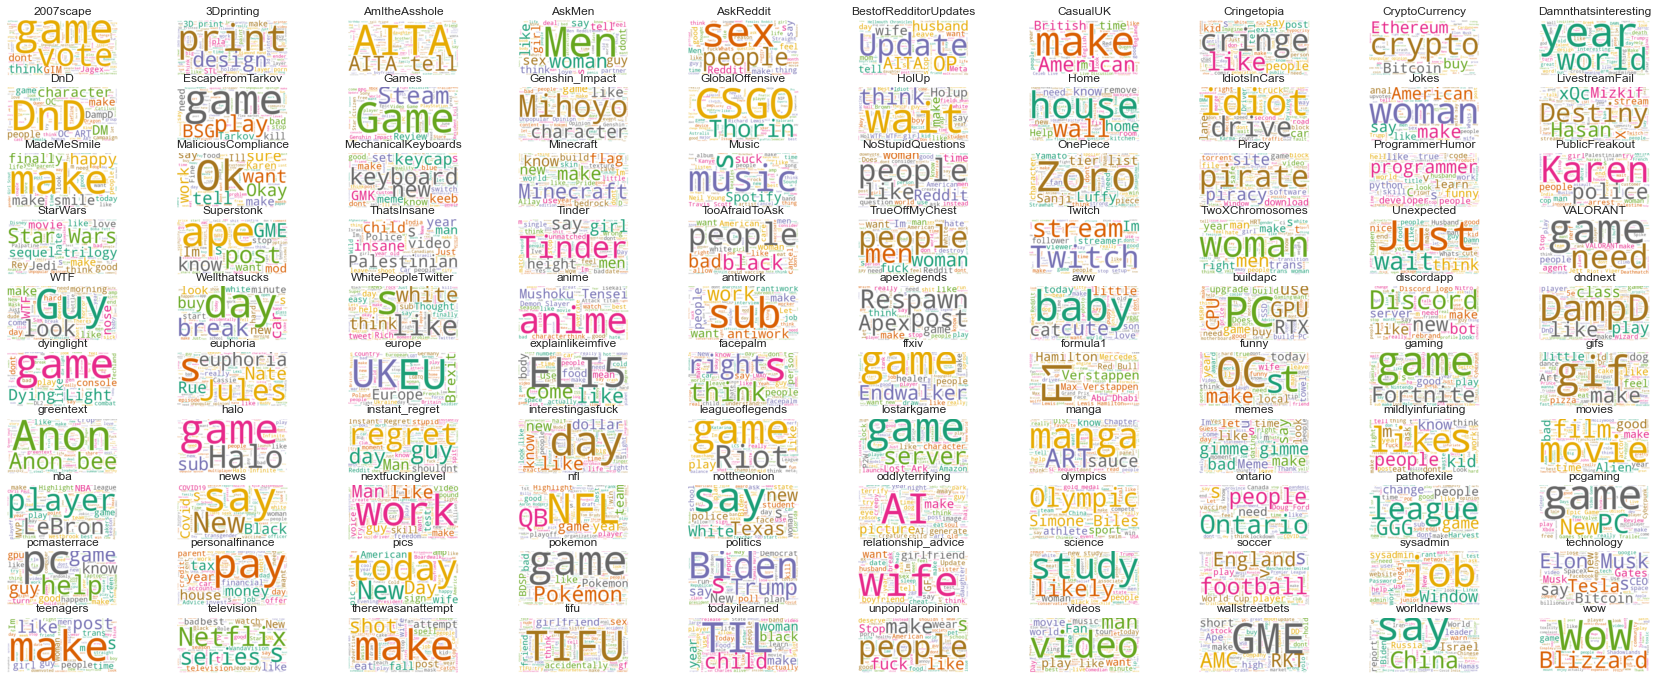

In [15]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 12]

full_names = [subreddit for subreddit in data_dtmm.columns]

# Create subplots for each comedian
for index, subreddit in enumerate(data_dtmm.columns):
    wc.generate(submission_corpus.at[submission_corpus['subreddit'].eq(subreddit).idxmax(), 'title'])
    
    plt.subplot(10, 10, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    
plt.show()

#### Insights:


Choice of words favoured by different communities.
- 

# Vocabulary

In [17]:
unique_list = []
for subreddit in data_dtmm.columns:
    uniques = data_dtmm[subreddit].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

data_words = pd.DataFrame(list(zip(full_names, unique_list)), columns=['subreddit', 'unique_words'])
data_unique_sort = data_words.sort_values(by="unique_words")
data_unique_sort.head()

subreddit  unique_words
67              memes           204
38         Unexpected           215
60          greentext           220
28    ProgrammerHumor           236
92  therewasanattempt           243

In [ ]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

my_stop_words = ['like', 'just', 'https', 'com']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(submission_corpus.title)
data_dtmm = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmm.index = submission_corpus.subreddit
data_dtmm

In [ ]:
from gensim import matutils, models
import scipy.sparse

corpus = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmm.transpose()))
id2word = dict((v,k) for k,v in cvn.vocabulary_.items())

In [ ]:
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=10)
lda.print_topics()

In [ ]:
lda = models.LdaModel(corpus=corpus, num_topics=8, id2word=id2word, passes=10)
lda.print_topics()